# Final Project.
by Handan Cetin | USCID: 6074572947 | github: handancetin

---

## 0. Data Retrieval

I used Google Collab for this project due to my computational limitations. Below three cells are for the data retrival and unpacking. I won't upload data files to GitHub repository, please run these lines to obtain the same results. Thank you!

In [ ]:
## COMMAND-LINE OPERATIONS

# Get the repository via git bash
!git clone https://github.com/DSCI-552/final-project-handancetin.git

# Go to the repository folder
!cd 'final-project-handancetin/'

# Download the data from the link provided
!wget -O data.zip -- http://dataverse.jpl.nasa.gov/api/access/datafile/83039

# Unzip (inflate) the downloaded data
!unzip data.zip # Note: Data folder will be in the same directory with this notebook

## 1. Identification of Frost in Martian HiRISE Images

####  1. (a) Introduction
In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost.
This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate

#### 1. (b) Data Exploration and Pre-processing

##### 1. (b) i. Configuration
Images (png files) and labels (json files) are organized in the data directory by “subframes.” Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels). Individual subframes were annotated by the contributors and then sliced into 299x299 “tiles.” Each tile has an associated label for use in training ML algorithms.

There are 214 subframes and a total of 119920 tiles. Each tile has annotations which have been used to assign labels to the tiles ‘frost’ or ‘background.’ Each JSON file contains all the annotation information collected from human annotators.
The following are relevant to the assignment:

Image tiles are organized into folders of ‘background’ and ‘frost’ classes (binary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # for plots

import os.path as op
import json
from pathlib import Path
import shutil
import logging
from tqdm import tqdm
from skimage import io
from PIL import Image

import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

# Head directory containing all image subframes
data_head_dir = Path('data/')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

##### 1. (b) ii. Preprocessing
The dataset includes files for splitting the data into train, test and validation. However, you will be provided by an improved version of those files when a repo is created:
* A. train source images.txt
* B. test source images.txt
* C. val source images.txt

In [ ]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids    = load_text_ids('train_source_images.txt')
validate_ids = load_text_ids('val_source_images.txt')
test_ids     = load_text_ids('test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [ ]:
def load_subdir_data(dir_path, image_size, seed=None):
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    loc_list = []
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list

# Loop over all subframes, loading each into a list
IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17
data_train, data_test, data_val = [], [], []
for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split == 'validate':
        data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split == 'train':
        data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split == 'test':
        data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

# Seperate features and labels
random.shuffle(data_train)
random.shuffle(data_val)
random.shuffle(data_test)

train_img_list, train_label_list = zip(*data_train)
val_img_list,   val_label_list   = zip(*data_val)
test_img_list,  test_label_list  = zip(*data_test)

In [ ]:
print('There is total of', len(train_img_list), 'images in the training set.')
print('There is total of', len(val_img_list), 'images in the validation set.')
print('There is total of', len(test_img_list), 'images in the test set.')

There is total of 29679 images in the training set.
There is total of 11286 images in the validation set.
There is total of 12823 images in the test set.


In [ ]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        label_str = label.numpy().decode('utf-8')
        img_loc = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc).convert('RGB')
        return img, 1 if label_str=='frost' else 0 # 1=frost, 0=background

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # force the shapes
    X.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    y.set_shape([])

    return X, y

In [ ]:
# Set the batch and buffer size
buffer_size = 128
batch_size = 128

# Validation Set
tf_dataset_val = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_img_list), tf.convert_to_tensor(val_label_list)))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size = buffer_size)
tf_dataset_val = tf_dataset_val.batch(batch_size)

# Testing Set
tf_dataset_test = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_img_list), tf.convert_to_tensor(test_label_list)))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size = buffer_size)
tf_dataset_test = tf_dataset_test.batch(batch_size)

# Training Set
tf_dataset_train = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_img_list), tf.convert_to_tensor(train_label_list)))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size = buffer_size)
tf_dataset_train = tf_dataset_train.batch(batch_size)


##### 1. (b) iii. Examples
Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).

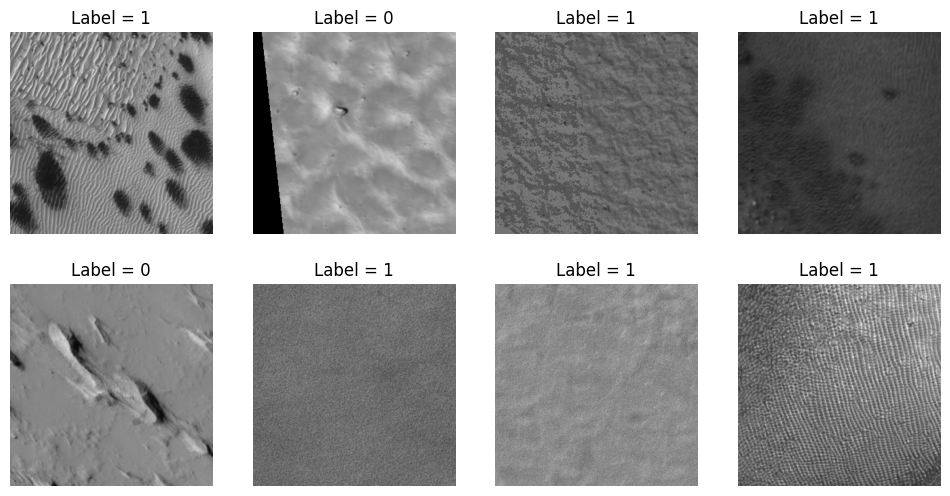

In [ ]:
# Explore random images from training set as example
plt.figure(figsize=(12, 6))
for images, labels in tf_dataset_train.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('Label = ' + str(labels[i].numpy()))
    plt.axis("off")
  break

#### 1. (c) Training CNN + MLP

##### 1. (c) i. Image Augmentation
To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [ ]:
# Set up an augmentation model
augmentation_model = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                          tf.keras.layers.RandomRotation(0.2),
                                          tf.keras.layers.RandomZoom(0.2),
                                          tf.keras.layers.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                          tf.keras.layers.RandomContrast(0.2),
                                          tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])
                                          ])

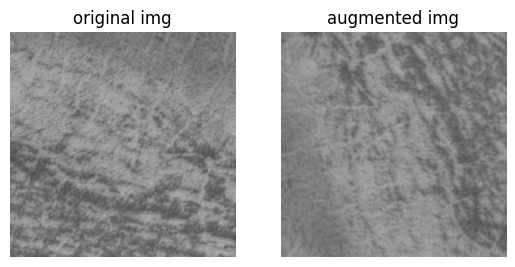

In [ ]:
# Pick a random image to apply augmentation
for image, label in tf_dataset_train.take(1):
    before = image[0]
    after = augmentation_model(before)
    break

# See if the augmentation is acceptable
plt.subplot(1, 2, 1)
plt.imshow(before.numpy().astype('uint8'))
plt.title('original img')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(after.numpy().astype('uint8'))
plt.title('augmented img')
plt.axis("off")

plt.show() #looks good enough

In [ ]:
# Create an augmented set from training
tf_dataset_augmented = tf_dataset_train.map(lambda x, y: (augmentation_model(x), y))

# Add the augmented datapoints to the training. So we will have 2X datapoints.
tf_dataset_train_aug = tf_dataset_train.concatenate(tf_dataset_augmented)

for x, y in tf_dataset_train_aug.take(1):
    print("Augmented training batch shape:", x.shape, y.shape)
    break

Augmented training batch shape: (128, 299, 299, 3) (128,)


##### 1. (c) ii. CNN + MLP
Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization, and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [ ]:
# Setup the parameters
kernel_size = (3, 3) # captures locality and computationally efficient, should be okay
depth = 32 # randomly chosen
dense_units = 128 # randomly chosen
dropout_rate = 0.3
l2_param = 0.01 #  randomly chosen
learning = 0.0001 #  randomly chosen

# Three-layer CNN model (using ReLU and batch normalization in every layer)

# set the model
model = tf.keras.models.Sequential()

# layer 1
model.add(tf.keras.layers.Conv2D(depth, kernel_size, padding = 'same',
                                 input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                 kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# layer 2
model.add(tf.keras.layers.Conv2D(depth*2, kernel_size, padding = 'same',
                                 kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# layer 3
model.add(tf.keras.layers.Conv2D(depth*4, kernel_size,  padding = 'same',
                                 kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense_units, activation = 'relu',
                                kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.Dropout(dropout_rate))

# softmax layer
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

# Get the model
model.compile(optimizer = Adam(learning_rate = learning),
              loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
              # I tried loss='binary', metrics='binary_accuracy' with dense
              # output as 1, however it always classified as 1 and never 0.
              # that model did not train and remained dumb/ignorant. :/
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 299, 299, 32)      128       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 299, 299, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 74, 74, 64)       

In [ ]:
# Set up the callback function
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)

# Train the model
model_trained = model.fit(tf_dataset_train_aug, batch_size = batch_size, epochs = 20,
                          validation_data = tf_dataset_val, callbacks = early_stopping)

# Each epoch takes ~15 minutes to be completed. First half ofthe training data
# passes through in 3 minutes (the original training set), however, the second
# half (augmented set) takes 12 minutes. Mapping of 2 functions consecutively
# can be improved in the future runs.

Epoch 1/20
464/464 [==============================] - 851s 2s/step - loss: 3.3731 - accuracy: 0.7928 - val_loss: 2.9817 - val_accuracy: 0.6637
Epoch 2/20
464/464 [==============================] - 834s 2s/step - loss: 2.2172 - accuracy: 0.8666 - val_loss: 2.4273 - val_accuracy: 0.6273
Epoch 3/20
464/464 [==============================] - 824s 2s/step - loss: 1.6227 - accuracy: 0.8975 - val_loss: 2.1235 - val_accuracy: 0.6216
Epoch 4/20
464/464 [==============================] - 825s 2s/step - loss: 1.2611 - accuracy: 0.9128 - val_loss: 1.7090 - val_accuracy: 0.7364
Epoch 5/20
464/464 [==============================] - 828s 2s/step - loss: 1.0110 - accuracy: 0.9275 - val_loss: 1.5368 - val_accuracy: 0.7194
Epoch 6/20
464/464 [==============================] - 824s 2s/step - loss: 0.8446 - accuracy: 0.9332 - val_loss: 3.2706 - val_accuracy: 0.4070
Epoch 7/20
464/464 [==============================] - 824s 2s/step - loss: 0.7262 - accuracy: 0.9368 - val_loss: 4.2124 - val_accuracy: 0.3488

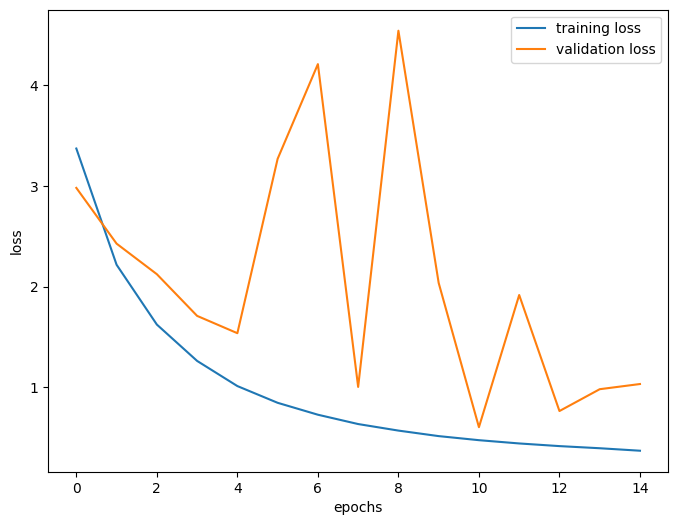

In [ ]:
# Training automatically stopped at 15th epoch due to early stopping (see piazza @1116)

# Plot training and validation errors vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(model_trained.history['loss'], label = 'training loss')
plt.plot(model_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

##### 1. (c) iii. Metrics Report
Report precision, recall, and F1 score of your model.

In [ ]:
# Perform the prediction on the test set
predicted_test_probs = model.predict(tf_dataset_test)
predicted_test_labels = np.argmax(predicted_test_probs, axis=1)
true_test_labels = [1 if item == 'frost' else 0 for item in test_label_list]

# Print metrics
report_test = classification_report(true_test_labels, predicted_test_labels) # last 15 elements are dropped for equal batch sizes
print('Metrics for the testing set predictions:\n')
print(report_test)

101/101 [==============================] - 35s 339ms/step
Metrics for the testing set predictions:

              precision    recall  f1-score   support

           0       0.35      0.33      0.34      4418
           1       0.66      0.67      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.56      0.56     12823



In [ ]:
# Perform the prediction on the training set
predicted_train_probs = model.predict(tf_dataset_train)
predicted_train_labels = np.argmax(predicted_train_probs, axis=1)
true_train_labels = [1 if item == 'frost' else 0 for item in train_label_list]

# Print metrics
report_train = classification_report(true_train_labels, predicted_train_labels) # last 15 elements are dropped for equal batch sizes
print('\nMetrics for the training set predictions:\n')
print(report_train)

232/232 [==============================] - 79s 339ms/step

Metrics for the training set predictions:

              precision    recall  f1-score   support

           0       0.41      0.46      0.43     12235
           1       0.59      0.54      0.56     17444

    accuracy                           0.51     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.51      0.51     29679



In [ ]:
# Perform the prediction on the validation set
predicted_val_probs = model.predict(tf_dataset_val)
predicted_val_labels = np.argmax(predicted_val_probs, axis=1)
true_val_labels = [1 if item == 'frost' else 0 for item in val_label_list]

# Print metrics
report_val = classification_report(true_val_labels, predicted_val_labels) # last 15 elements are dropped for equal batch sizes
print('\nMetrics for the training set predictions:\n')
print(report_val)

89/89 [==============================] - 28s 311ms/step

Metrics for the training set predictions:

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      7654
           1       0.32      0.43      0.37      3632

    accuracy                           0.52     11286
   macro avg       0.50      0.50      0.49     11286
weighted avg       0.56      0.52      0.54     11286



##### ***Discussion on CNN + MLP***

During the training, we achieved 95.7% accuracy with the augmented training set and 89.0% accuracy with the validation set. When we get our predictions on the test data, we see that metrics are not even close.

The overall accuracy of the model is 56% from the testing set. We can clearly say the model does not perform great with the hyperparameters we set up. We can see that precision is higher for the first class (0.35 vs. 0.65), thus, if our aim was to prioritize correct predictions only for the frost class images (and not care for the background images), we could argue that the model's performance is better than a randomized model. We can also see that with the macro average of 0.5, both classes contributed evenly in the training, which is good.

The drop in the accuracy is also due to the augmented data. Even though it was only 2X augmentation, it affected the model's training significantly, caused overfiting during the training.

Just for looking at the metrics, at first, we may not directly say the model is overfit given that the metrics for training data has slightly lower accuracy compared to the testing metrics (51% vs 56%). However, the precision is better for the background class instead of the frost class with the validation set. Observing that testing and validation set results are varied, we can easily say that model is not robust and overfitted to the training data.

There is no free lunch, so we should perform further model tuning and/or various regularization techniques to obtain a better performant model. Given constraints on the project details, I chose my hyperparameters to be computationally efficient and wanted to implement all possible augmentation techniques. I have read that some students achieved >90% accuracy on testing set on Piazza, I am intrigued to try their parameters to see the improvement. For now, I have to accept this model's results and continue to the second section.

In [ ]:
# # Save the trained model as a '.keras' zip archive, for backup.
# model.save('project_model.keras')
#
# #  Clear the previous model details for memory
# del model
# tf.keras.backend.clear_session()
# gc.collect()

108

### 1. (d) Transfer Learning

##### 1. (d) i. Data Preprocessing
When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers.

In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

In [ ]:
# Update the batch size for transfer learning
buffer_size = 128
batch_size = 8 # NOTE: System uses >20GB or RAM!

# In order to gain speed, I will continue with 50% of each dataset.
def selec_first_perc(list, percent):
    end_idx = int(np.ceil(len(list) * (percent/100)))
    return list[:end_idx]

# 50% of Validation Set
tf_dataset_val_TL = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(selec_first_perc(val_img_list, 50)),
                                                        tf.convert_to_tensor(selec_first_perc(val_label_list, 50))))
tf_dataset_val_TL = tf_dataset_val_TL.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val_TL = tf_dataset_val_TL.shuffle(buffer_size = buffer_size)
tf_dataset_val_TL = tf_dataset_val_TL.batch(batch_size)

# 50% of Testing Set
tf_dataset_test_TL = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(selec_first_perc(test_img_list, 50)),
                                                         tf.convert_to_tensor(selec_first_perc(test_label_list, 50))))
tf_dataset_test_TL = tf_dataset_test_TL.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_TL = tf_dataset_test_TL.shuffle(buffer_size = buffer_size)
tf_dataset_test_TL = tf_dataset_test_TL.batch(batch_size)

# 50% of Training Set
tf_dataset_train_TL = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(selec_first_perc(train_img_list, 50)),
                                                          tf.convert_to_tensor(selec_first_perc(train_label_list, 50))))
tf_dataset_train_TL = tf_dataset_train_TL.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_TL = tf_dataset_train_TL.shuffle(buffer_size = buffer_size)
tf_dataset_train_TL = tf_dataset_train_TL.batch(batch_size)

##### 1. (d) ii. Image Augmentation
To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [ ]:
# A simpler augmentation model (lower memory usage)
augmentation_model_TL = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                             tf.keras.layers.RandomRotation(0.2)])

# Create an augmented set from training
tf_dataset_augmented_TL = tf_dataset_train_TL.map(lambda x, y: (augmentation_model_TL(x), y))

# Add the augmented datapoints to the training. So we will have 2X datapoints.
tf_dataset_train_aug_TL = tf_dataset_train_TL.concatenate(tf_dataset_augmented_TL)

for x, y in tf_dataset_train_aug_TL.take(1):
    print("Augmented training batch shape:", x.shape, y.shape)
    break

Augmented training batch shape: (8, 299, 299, 3) (8,)


##### 1. (d) iii. Model Setup
Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 5 and a dropout rate of 30% as well as ADAM optimizer. Use cross entropy loss. You can try any batch size, but a batch size of 8 seems reasonable.

In [ ]:
# Download pre-trained model: EfficientNetB0
model_ENet   = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model_ENet.trainable = False # freeze

In [ ]:
# Setup the last layer
model_ENet_modified = tf.keras.models.Sequential([model_ENet,
                                                  tf.keras.layers.GlobalAveragePooling2D(),
                                                  tf.keras.layers.Dense(128, activation = 'relu'),
                                                  tf.keras.layers.BatchNormalization(),
                                                  tf.keras.layers.ReLU(),
                                                  tf.keras.layers.Dropout(0.3), # predetermined parameter
                                                  tf.keras.layers.Dense(2, activation = 'softmax') ])

# Get the model: EfficientNetB0
model_ENet_modified.compile(optimizer = Adam(learning_rate = 0.0001),
                            loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model_ENet_modified.summary()  #commented out, long verbose

##### 1. (d) iv. Training
Train using the features calculated by networks (EfficientNetB0, ResNet50, and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [ ]:
# Set up the callback function
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
# EfficientNetB0: Perform training
model_ENet_trained = model_ENet_modified.fit(tf_dataset_train_aug_TL, batch_size = batch_size, epochs = 10,   # batch_size=8
                                             validation_data = tf_dataset_val_TL, callbacks = early_stopping) # same callback
                                             # Each epoch takes ~12 minutes to be completed.

Epoch 1/10
3710/3710 [==============================] - 678s 180ms/step - loss: 0.2610 - accuracy: 0.8932 - val_loss: 0.4916 - val_accuracy: 0.7698
Epoch 2/10
3710/3710 [==============================] - 721s 194ms/step - loss: 0.1533 - accuracy: 0.9420 - val_loss: 0.5335 - val_accuracy: 0.7934
Epoch 3/10
3710/3710 [==============================] - 662s 178ms/step - loss: 0.1247 - accuracy: 0.9536 - val_loss: 0.5589 - val_accuracy: 0.8003
Epoch 4/10
3710/3710 [==============================] - 661s 178ms/step - loss: 0.1102 - accuracy: 0.9597 - val_loss: 0.5344 - val_accuracy: 0.8347
Epoch 5/10
3710/3710 [==============================] - 672s 181ms/step - loss: 0.1003 - accuracy: 0.9633 - val_loss: 0.6613 - val_accuracy: 0.8024
Epoch 6/10
3710/3710 [==============================] - 660s 178ms/step - loss: 0.0989 - accuracy: 0.9630 - val_loss: 0.6886 - val_accuracy: 0.8109


##### 1. (d) v. Metrics Report
Report Precision, Recall, and F1 score for your model.

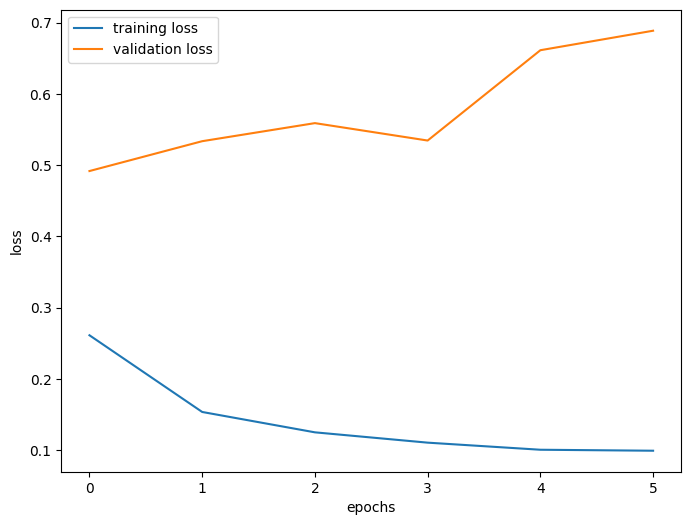

In [ ]:
# EfficientNetB0: Plot training and validation errors vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(model_ENet_trained.history['loss'], label = 'training loss')
plt.plot(model_ENet_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# EfficientNetB0: Perform the prediction on the TEST set
predicted_test_probs_ENet = model_ENet_modified.predict(tf_dataset_test_TL)
predicted_test_labels_ENet = np.argmax(predicted_test_probs_ENet, axis=1)
true_test_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(test_label_list, 50)]

# EfficientNetB0: Print metrics
report_test_ENet = classification_report(true_test_labels_TL, predicted_test_labels_ENet)
print('EfficientNetB0 transfer learning metrics for the testing set predictions:\n')
print(report_test_ENet)

802/802 [==============================] - 114s 139ms/step
EfficientNetB0 transfer learning metrics for the testing set predictions:

              precision    recall  f1-score   support

           0       0.34      0.27      0.30      2232
           1       0.65      0.72      0.69      4180

    accuracy                           0.57      6412
   macro avg       0.50      0.50      0.49      6412
weighted avg       0.54      0.57      0.55      6412



In [ ]:
# EfficientNetB0: Perform the prediction on the VALIDATION set
predicted_val_probs_ENet = model_ENet_modified.predict(tf_dataset_val_TL)
predicted_val_labels_ENet = np.argmax(predicted_val_probs_ENet, axis=1)
true_val_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(val_label_list, 50)]

# EfficientNetB0: Print metrics
report_val_ENet = classification_report(true_val_labels_TL, predicted_val_labels_ENet)
print('ENet transfer learning metrics for the validation set predictions:\n')
print(report_val_ENet)

706/706 [==============================] - 100s 141ms/step
ENet transfer learning metrics for the validation set predictions:

              precision    recall  f1-score   support

           0       0.68      0.45      0.54      3852
           1       0.31      0.54      0.40      1791

    accuracy                           0.48      5643
   macro avg       0.50      0.50      0.47      5643
weighted avg       0.56      0.48      0.50      5643



In [ ]:
# EfficientNetB0: Perform the prediction on the TRAINING set
predicted_train_probs_ENet = model_ENet_modified.predict(tf_dataset_train_TL)
predicted_train_labels_ENet = np.argmax(predicted_train_probs_ENet, axis=1)
true_train_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(train_label_list, 50)]

# EfficientNetB0: Print metrics
report_train_ENet = classification_report(true_train_labels_TL, predicted_train_labels_ENet)
print('ENet transfer learning metrics for the training set predictions:\n')
print(report_train_ENet)

1855/1855 [==============================] - 267s 144ms/step
ENet transfer learning metrics for the training set predictions:

              precision    recall  f1-score   support

           0       0.42      0.38      0.40      6181
           1       0.58      0.63      0.60      8659

    accuracy                           0.52     14840
   macro avg       0.50      0.50      0.50     14840
weighted avg       0.52      0.52      0.52     14840



In [ ]:
# Saving methods does not work for this model (tf version not compatible)
# See: https://discuss.tensorflow.org/t/using-efficientnetb0-and-save-model-
# will-result-unable-to-serialize-2-0896919-2-1128857-2-1081853-to-json-unreco
# gnized-type-class-tensorflow-python-framework-ops-eagertensor/12518/31

---
**Same pipeline with the pre-trained ResNet50 model:**

In [ ]:
# Download pre-trained model: ResNet50
model_ResNet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model_ResNet.trainable = False # freeze

# Setup the last layer for ResNet50
model_ResNet_modified = tf.keras.models.Sequential([model_ResNet,
                                                    tf.keras.layers.GlobalAveragePooling2D(),
                                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                                    tf.keras.layers.BatchNormalization(),
                                                    tf.keras.layers.ReLU(),
                                                    tf.keras.layers.Dropout(0.3), # predetermined parameter
                                                    tf.keras.layers.Dense(2, activation = 'softmax') ])
# Get the model
model_ResNet_modified.compile(optimizer = Adam(learning_rate = 0.0001),
                              loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# ResNet50: Perform training
model_ResNet_trained = model_ResNet_modified.fit(tf_dataset_train_aug_TL, batch_size = batch_size, epochs = 10,
                                                 validation_data = tf_dataset_val_TL, callbacks = early_stopping)
                                                # Each epoch takes ~12 minutes to be completed.

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
3710/3710 [==============================] - 1161s 312ms/step - loss: 0.2276 - accuracy: 0.9112 - val_loss: 0.6633 - val_accuracy: 0.7565
Epoch 2/10
3710/3710 [==============================] - 1153s 311ms/step - loss: 0.1358 - accuracy: 0.9508 - val_loss: 0.7290 - val_accuracy: 0.7496
Epoch 3/10
3710/3710 [==============================] - 1138s 307ms/step - loss: 0.1084 - accuracy: 0.9597 - val_loss: 0.6758 - val_accuracy: 0.7537
Epoch 4/10
3710/3710 [==============================] - 1147s 309ms/step - loss: 0.1048 - accuracy: 0.9617 - val_loss: 0.9106 - val_accuracy: 0.7200
Epoch 5/10
3710/3710 [==============================] - 1133s 305ms/step - loss: 0.0901 - accuracy: 0.9688 - val_loss: 0.7814 - val_accuracy: 0.7666
Epoch 6/10
3710/3710 [==============================] - 1129s 304ms/step - loss: 0.0845 - accuracy: 0.9680 - val_loss: 0.7673 - val_accuracy: 0.7927


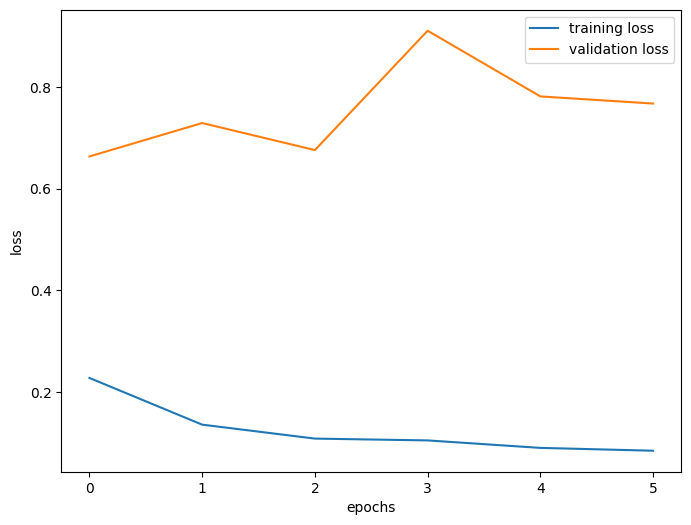

In [ ]:
# ResNet50: Plot errors vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(model_ResNet_trained.history['loss'], label = 'training loss')
plt.plot(model_ResNet_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# ResNet50: Perform the prediction on the TEST set
predicted_test_probs_ResNet = model_ResNet_modified.predict(tf_dataset_test_TL)
predicted_test_labels_ResNet = np.argmax(predicted_test_probs_ResNet, axis=1)
true_test_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(test_label_list, 50)]

# ResNet50: Print metrics
report_test_ResNet = classification_report(true_test_labels_TL, predicted_test_labels_ResNet)
print('ResNet50 transfer learning metrics for the testing set predictions:\n')
print(report_test_ResNet)

802/802 [==============================] - 206s 255ms/step
ResNet50 transfer learning metrics for the testing set predictions:

              precision    recall  f1-score   support

           0       0.36      0.29      0.32      2232
           1       0.66      0.72      0.69      4180

    accuracy                           0.57      6412
   macro avg       0.51      0.51      0.50      6412
weighted avg       0.55      0.57      0.56      6412



In [ ]:
# ResNet50: Perform the prediction on the VALIDATION set
predicted_val_probs_ResNet = model_ResNet_modified.predict(tf_dataset_val_TL)
predicted_val_labels_ResNet = np.argmax(predicted_val_probs_ResNet, axis=1)
true_val_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(val_label_list, 50)]

# ResNet50: Print metrics
report_val_ResNet = classification_report(true_val_labels_TL, predicted_val_labels_ResNet)
print('ResNet50 transfer learning metrics for the validation set predictions:\n')
print(report_val_ResNet)

706/706 [==============================] - 184s 260ms/step
ResNet50 transfer learning metrics for the validation set predictions:

              precision    recall  f1-score   support

           0       0.70      0.46      0.55      3852
           1       0.33      0.58      0.42      1791

    accuracy                           0.50      5643
   macro avg       0.52      0.52      0.49      5643
weighted avg       0.59      0.50      0.51      5643



In [ ]:
# ResNet50: Perform the prediction on the TRAINING set
predicted_train_probs_ResNet = model_ResNet_modified.predict(tf_dataset_train_TL)
predicted_train_labels_ResNet = np.argmax(predicted_train_probs_ResNet, axis=1)
true_train_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(train_label_list, 50)]

# ResNet50: Print metrics
report_train_ResNet = classification_report(true_train_labels_TL, predicted_train_labels_ResNet)
print('ResNet50 transfer learning metrics for the training set predictions:\n')
print(report_train_ResNet)

1855/1855 [==============================] - 486s 262ms/step
ResNet50 transfer learning metrics for the training set predictions:

              precision    recall  f1-score   support

           0       0.42      0.40      0.41      6181
           1       0.58      0.60      0.59      8659

    accuracy                           0.52     14840
   macro avg       0.50      0.50      0.50     14840
weighted avg       0.51      0.52      0.51     14840



---
**Same pipeline with the pre-trained VGG16 model:**

In [ ]:
# Download pre-trained model: VGG16
model_VGG16 = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model_VGG16.trainable = False # freeze

# Setup the last layer
model_VGG16_modified = tf.keras.models.Sequential([model_VGG16,
                                                    tf.keras.layers.GlobalAveragePooling2D(),
                                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                                    tf.keras.layers.BatchNormalization(),
                                                    tf.keras.layers.ReLU(),
                                                    tf.keras.layers.Dropout(0.3), # predetermined parameter
                                                    tf.keras.layers.Dense(2, activation = 'softmax') ])

# Get the model
model_VGG16_modified.compile(optimizer = Adam(learning_rate = 0.0001),
                              loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# VGG16: Perform training
model_VGG16_trained = model_VGG16_modified.fit(tf_dataset_train_aug_TL, batch_size = batch_size, epochs = 10,
                                               validation_data = tf_dataset_val_TL, callbacks = early_stopping) #same callback
                                               # Each epoch takes ~38 minutes to be completed.

Epoch 1/10
3710/3710 [==============================] - 2193s 591ms/step - loss: 0.3814 - accuracy: 0.8289 - val_loss: 0.3984 - val_accuracy: 0.8123
Epoch 2/10
3710/3710 [==============================] - 2122s 572ms/step - loss: 0.2347 - accuracy: 0.9078 - val_loss: 0.4204 - val_accuracy: 0.8091
Epoch 3/10
3710/3710 [==============================] - 2141s 577ms/step - loss: 0.1817 - accuracy: 0.9319 - val_loss: 0.4429 - val_accuracy: 0.7902
Epoch 4/10
3710/3710 [==============================] - 2122s 572ms/step - loss: 0.1620 - accuracy: 0.9396 - val_loss: 0.4442 - val_accuracy: 0.7980
Epoch 5/10
3710/3710 [==============================] - 2124s 572ms/step - loss: 0.1430 - accuracy: 0.9455 - val_loss: 0.3810 - val_accuracy: 0.8359
Epoch 6/10
3710/3710 [==============================] - 2139s 577ms/step - loss: 0.1302 - accuracy: 0.9525 - val_loss: 0.5230 - val_accuracy: 0.7764
Epoch 7/10
3710/3710 [==============================] - 2146s 578ms/step - loss: 0.1181 - accuracy: 0.9563

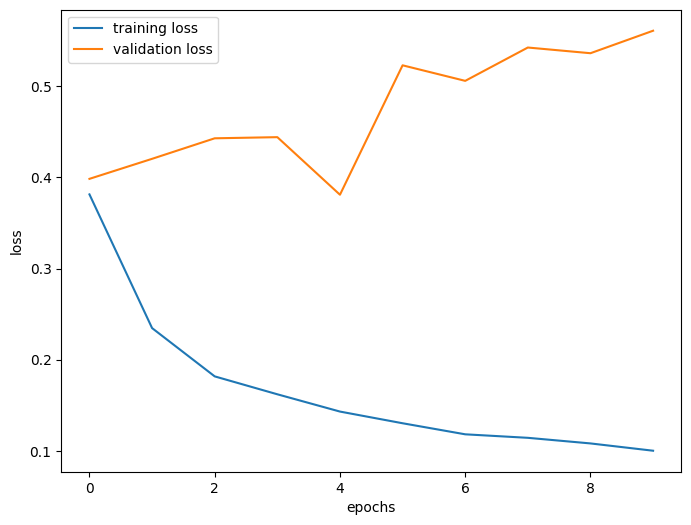

In [ ]:
# VGG16: Plot errors vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(model_VGG16_trained.history['loss'], label = 'training loss')
plt.plot(model_VGG16_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# VGG16: Perform the prediction on the TEST set
predicted_test_probs_VGG16 = model_VGG16_modified.predict(tf_dataset_test_TL)
predicted_test_labels_VGG16 = np.argmax(predicted_test_probs_VGG16, axis=1)
true_test_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(test_label_list, 50)]

# VGG16: Print metrics
report_test_VGG16 = classification_report(true_test_labels_TL, predicted_test_labels_VGG16)
print('VGG16 transfer learning metrics for the testing set predictions:\n')
print(report_test_VGG16)

802/802 [==============================] - 375s 467ms/step
VGG16 transfer learning metrics for the testing set predictions:

              precision    recall  f1-score   support

           0       0.34      0.34      0.34      2151
           1       0.67      0.66      0.66      4261

    accuracy                           0.55      6412
   macro avg       0.50      0.50      0.50      6412
weighted avg       0.56      0.55      0.56      6412



In [ ]:
# VGG16: Perform the prediction on the VALIDATION set
predicted_val_probs_VGG16 = model_VGG16_modified.predict(tf_dataset_val_TL)
predicted_val_labels_VGG16 = np.argmax(predicted_val_probs_VGG16, axis=1)
true_val_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(val_label_list, 50)]

# VGG16: Print metrics
report_val_VGG16 = classification_report(true_val_labels_TL, predicted_val_labels_VGG16)
print('VGG16 transfer learning metrics for the validation set predictions:\n')
print(report_val_VGG16)

706/706 [==============================] - 329s 466ms/step
VGG16 transfer learning metrics for the validation set predictions:

              precision    recall  f1-score   support

           0       0.69      0.54      0.61      3851
           1       0.33      0.48      0.39      1792

    accuracy                           0.52      5643
   macro avg       0.51      0.51      0.50      5643
weighted avg       0.58      0.52      0.54      5643



In [ ]:
# VGG16: Perform the prediction on the TRAINING set
predicted_train_probs_VGG16 = model_VGG16_modified.predict(tf_dataset_train_TL)
predicted_train_labels_VGG16 = np.argmax(predicted_train_probs_VGG16, axis=1)
true_train_labels_TL = [1 if item == 'frost' else 0 for item in selec_first_perc(train_label_list, 50)]

# VGG16: Print metrics
report_train_VGG16 = classification_report(true_train_labels_TL, predicted_train_labels_VGG16)
print('VGG16 transfer learning metrics for the training set predictions:\n')
print(report_train_VGG16)

1855/1855 [==============================] - 881s 475ms/step
VGG16 transfer learning metrics for the training set predictions:

              precision    recall  f1-score   support

           0       0.42      0.42      0.42      6164
           1       0.59      0.59      0.59      8676

    accuracy                           0.52     14840
   macro avg       0.51      0.51      0.51     14840
weighted avg       0.52      0.52      0.52     14840



### 1. (d) vi. Comparison
Compare the results of transfer learning with those of CNN + MLP model and explain them.

First, let's summarize every model's testing metrics:

**Model with CNN + MLP**
* Accuracy (Testing): 0.56
* Precision: 0.35 / 0.66
* Recall: 0.33 / 0.67
* F1-Score: 0.34 / 0.67

**Transfer learning with EfficientNetB0**
* Accuracy (Testing): 0.57
* Precision: 0.34 / 0.65
* Recall: 0.27 / 0.72
* F1-Score: 0.30 / 0.69

**Transfer learning with ResNet50**
* Accuracy (Testing): 0.57
* Precision: 0.36 / 0.66
* Recall: 0.29 / 0.72
* F1-Score: 0.32 / 0.69

**Transfer learning with VGG16**
* Accuracy (Testing): 0.55
* Precision: 0.34 / 0.67
* Recall: 0.34 / 0.66
* F1-Score: 0.34 / 0.66

Just by looking at these testing metrics, we can see that transfer learning models with EfficientNetB0 and ResNet50 have the highest testing accuracy at 0.57. Transfer learning with VGG16 has the lowest testing accuracy at 0.55. Our model, CNN + MLP, has an accuracy of 0.56, right in the middle of transfer learning models.

If we look at the drops in accuracy from training to validation (epoch outputs), we see that in the CNN+MLP model, the validation loss is higher than the training loss. This is an indication of overfitting and potentially due to the augmentation. The gap between metrics is less in the transfer learning models, thus those models are more generalizated compared to the model we trained.

The transfer learning model with EfficientNetB0 has the best balance in terms of precision and recall. If our goal was to identify frost classes with minimum number of false positives, I would use this model to perform predictions.

Overall, this project proved "no free lunch" theorem, that is no single universally superior model for the task we had, and we should try multiple methods/approaches to find the best fitting case to achieve our aim. We built our own CNN + MLP architecture from scratch, and tested different transfer learning models using EfficientNetB0, ResNet50, and VGG16, each with its unique architecture. Although the metrics were not that various in my results, each model setup showed different performance (considering other student's metrics shared in piazza). We learnt the importance of choosing hyperparameters, applying various augmentation methods. Additionally, we experienced the computational dependency (in terms of hardware) for deep learning models from first-hand practice.